# Imports

In [1]:
import os

import torch
import shutil
import torchvision

import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import f1_score
from torchvision import transforms, models

# Dataset

In [2]:
train = pq.read_table('train.parquet').to_pandas()
train

product_id  category_id   sale  shop_id           shop_title   rating  \
0          325286        12171  False     9031                Aksik  5.00000   
1          888134        14233  False    18305                 Sela  5.00000   
3         1267173        13429  False    16357  ЮНЛАНДИЯ канцтовары  5.00000   
4         1416943         2789  False    34666        вася-nicotine  4.00000   
5         1058275        12834  False    26389           Lim Market  4.60000   
...           ...          ...    ...      ...                  ...      ...   
99987      114402        14922  False     4955         СТЕКЛОФФ ПРО  3.62069   
99988     1594500        13028  False    19626           Hobby room  5.00000   
99989      790493        13407  False    22291        Море открыток  5.00000   
99990      114509        12100  False     2985          Oppa Market  5.00000   
99992      122515        12100  False     2985          Oppa Market  5.00000   

                                             text_fields  
0      {"title": "Зарядный кабель Borofone BX1 Lightn...  
1      {"title": "Трусы Sela", "description": "Трусы-...  
3      {"title": "Гуашь \"ЮНЫЙ ВОЛШЕБНИК\", 12 цветов...  
4      {"title": "Колба для кальяна Крафт (разные цве...  
5      {"title": "Пижама женская, однотонная с шортам...  
...                                                  ...  
99987  {"title": "Прочное стекло 2D на Samsung Galaxy...  
99988  {"title": "Алмазная мозаика \"Ромашки\" 40*50с...  
99989  {"title": "Открытка \"Вместе навсегда\" в краф...  
99990  {"title": "Пульт K10B-C1 для Rolsen", "descrip...  
99992  {"title": "Пульт DS300A/DC300A/DN300 для цифро...  

[91120 rows x 7 columns]

In [3]:
len_category_id = len(train.category_id.unique())
len_category_id

874

In [4]:
# ImageFolder требует что бы был формат {category_id}/image
# он ставит изображению категорию родительского каталога
# поэтому нужно привести все в такой формат

train_dir = './sort_images/train/'
val_dir = './sort_images/val/'
data_root = './images/train'
class_names = train.category_id.unique()

# необходим, чтобы кидать в val картинки по каждой категорий отдельно
count_num_classes = {}

for class_name in class_names:
    count_num_classes[str(class_name)] = 0


def get_category_id(file_name: str) -> str:
    product_id = int(file_name.replace('.jpg', ''))
    res = train[train['product_id'] == product_id].category_id
    return str(res.values[0])


# если в папке нет изображении то удаляем её
def del_empty_folder() -> None:
    for class_name in tqdm(class_names):
        cl = str(class_name)
        if count_num_classes[cl] <= 1:
            print(f'del {cl}')
            shutil.rmtree(train_dir + cl)
            shutil.rmtree(val_dir + cl)


def sort_image() -> None:
    for dir_name in [train_dir, val_dir]:
        for class_name in class_names:
            os.makedirs(os.path.join(dir_name, str(class_name)), exist_ok=True)

    for file_name in tqdm(os.listdir(data_root)):
        class_name = get_category_id(file_name)
        source_dir = os.path.join(data_root, class_name)

        if count_num_classes[class_name] % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)

        count_num_classes[class_name] += 1

        shutil.copy(os.path.join(data_root, file_name), os.path.join(dest_dir, file_name))

    del_empty_folder()

In [5]:
# sort_image()

# Model

In [6]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    max_acc_history = -1
    best_epoch = -1

    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}:'.format(epoch, num_epochs), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()  # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if max_acc_history < epoch_acc:
                max_acc_history = epoch_acc
                best_epoch = epoch

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        print('Best epoch:', best_epoch, 'Best Accuracy:', max_acc_history.item())
        print('=' * 64)

        if epoch % 10 == 0:
            torch.save(model.state_dict(), f'cv_model_epoch_{epoch}')

    return model

In [7]:
# ResNet требует определенный формат данных
transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [8]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, len_category_id + 1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

C:\Users\narut\PycharmProjects\internship_2023\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\narut\PycharmProjects\internship_2023\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# train_model(model, loss, optimizer, scheduler, num_epochs=2);

In [10]:
# torch.save(model.state_dict(), 'cv_model_final')

# Check F1 score

In [11]:
def get_pred_category(arr: np.ndarray) -> tuple[int]:
    maxi = -1
    idx_max = -1
    for i in range(len(arr)):
        if maxi < arr[i]:
            maxi = arr[i]
            idx_max = i

    return idx_max

In [12]:
for_f1_score_val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False, num_workers=1)
model.load_state_dict(torch.load(f'models/cv_model'))
model.eval()


def get_predictions(model, dataloader: torch.utils.data.DataLoader) -> tuple[list, list]:
    test_predictions = []
    y = []

    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)

        with torch.set_grad_enabled(False):
            preds = model(inputs)

        soft_pred = torch.nn.functional.softmax(preds, dim=1).cpu().numpy()
        soft_pred = np.concatenate(soft_pred)
        test_predictions.append(get_pred_category(soft_pred))
        y.append(labels.numpy()[0])

    return test_predictions, y


test_predictions, y = get_predictions(model, for_f1_score_val_dataloader)

100%|██████████| 15548/15548 [06:03<00:00, 42.79it/s]


In [13]:
F1 = f1_score(y, test_predictions, average='weighted')
F1

0.50639360979348

In [ ]:
list_f1_score = []
model_names = []

In [16]:
for i in range(5, 7):
    model = models.resnet50(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, len_category_id + 1)

    for param in model.parameters():
        param.requires_grad = False


    model = model.to(device)
    model.load_state_dict(torch.load(f'models/cv_model_epoch_{i * 10}'))
    model.eval()

    test_predictions, y = get_predictions(model, for_f1_score_val_dataloader)

    f1 = f1_score(y, test_predictions, average='weighted')

    model_names.append(str(i * 10))
    list_f1_score.append(f1)

    print(f'{i * 10}: {f1}')

C:\Users\narut\PycharmProjects\internship_2023\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\narut\PycharmProjects\internship_2023\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 15548/15548 [05:36<00:00, 46.26it/s]
C:\Users\narut\PycharmProjects\internship_2023\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\naru

50: 0.6391586534342797


100%|██████████| 15548/15548 [05:45<00:00, 44.96it/s]

60: 0.6290633064581497


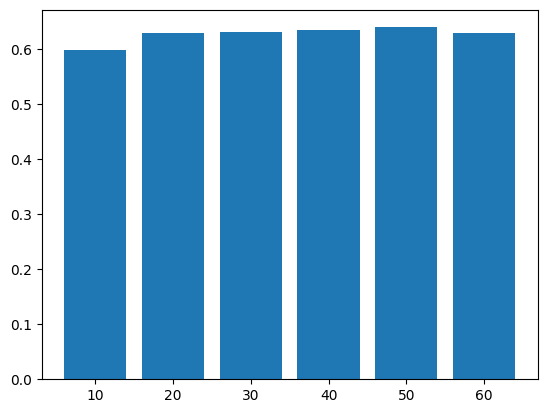

In [17]:
plt.bar(model_names, list_f1_score)
plt.show()